In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
from sklearn.ensemble import RandomForestRegressor
import fancyimpute

Using TensorFlow backend.


In [2]:
years = [2009,2010,2011,2012,2013,2014,2015]
path ='/public/npatil4/dataMining/data/daily/combined_wide/'
files = [path+'combined_wide_'+str(year)+'.csv' for year in years]

In [3]:
data = [pd.read_csv(file_name,sep='|') for file_name in files]

In [4]:
[df.shape for df in data]

[(148428, 18),
 (160416, 18),
 (157975, 18),
 (168291, 18),
 (184197, 18),
 (196085, 18),
 (206363, 18)]

In [5]:
data= pd.concat(data, ignore_index=True)

In [6]:
data['DateLocal'] = pd.to_datetime(data.DateLocal)
data['year'] = data.DateLocal.dt.year
data['weekNo'] = data.DateLocal.dt.week
data['Weekday'] = data.DateLocal.dt.weekday

In [7]:
data.head(2).transpose()

,0,1
DateLocal,2009-01-01 00:00:00,2009-01-01 00:00:00
CityName,Aberdeen,Adjuntas
CountyName,Brown,Adjuntas
StateName,South Dakota,Puerto Rico
Latitude,45.4625,18.17538
Longitude,-98.48611,-66.72599
Barometricpressure,NaN,NaN
Carbonmonoxide,NaN,NaN
DewPoint,NaN,NaN
NitrogenDioxide,NaN,NaN


In [8]:
data_missing = data.apply(pd.isnull)

In [9]:
100 * data_missing.ix[:,6:-4].apply(sum)/data_missing.shape[0]

Barometricpressure    81.756326
Carbonmonoxide        76.663324
DewPoint              98.023335
NitrogenDioxide       70.833923
OutdoorTemperature    66.338505
Ozone                 54.405752
PM                     0.000000
RelativeHumidity      78.592762
Sulfurdioxide         72.999251
WindSpeed             71.541185
dtype: float64

In [10]:
data_missing_count = data_missing.ix[:,6:-4].apply(sum,1).groupby([data.CountyName,
                                                                   data.CityName]
                                                                 ).mean()
data_missing_count = pd.DataFrame(data_missing_count[data_missing_count>=8]).reset_index()

In [11]:
data_pol = data.ix[:,:-4].groupby([
       'CityName', 'CountyName',
        'Latitude','Longitude'],
        as_index=False).mean()

In [12]:
pollution_heatmap = folium.Map(location=[data_pol['Latitude'].mean(),
                                         data_pol['Longitude'].mean()],
                               zoom_start=4)
pollution_heatmap.add_children(
    plugins.HeatMap(
        [[row["Latitude"], row["Longitude"],row['PM']]
         for name, row in data_pol.iterrows()]
    ))
#schools_heatmap.save("heatmap.html")
pollution_heatmap

In [13]:
data_pol = data.ix[:,:-4].groupby([
       'DateLocal',
       'CityName', 'CountyName',
       'Latitude','Longitude'],
        as_index=False).mean()


In [14]:
columns = [
 'Carbonmonoxide',
 'DewPoint',
 'NitrogenDioxide',
 'OutdoorTemperature',
 'Ozone',
 'PM',
 'RelativeHumidity',
 'Sulfurdioxide'
]

In [15]:
q = data_pol[columns].isnull().apply(sum,axis='columns')
z = np.append(q[q==1].index.values,q[q==0].index.values)

In [16]:
X_incomplete = data_pol.ix[:,columns]
X_incomplete.head()

,Carbonmonoxide,DewPoint,NitrogenDioxide,OutdoorTemperature,Ozone,PM,RelativeHumidity,Sulfurdioxide
0,NaN,NaN,NaN,NaN,NaN,5.20,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,3.90,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,7.90,NaN,2.576708
3,NaN,NaN,NaN,NaN,NaN,7.90,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,4.95,NaN,NaN


In [17]:
X_incomplete.shape

(1221755, 8)

In [18]:
from __future__ import absolute_import, print_function, division

from six.moves import range
from numpy import dot, append, column_stack, ones
from numpy.linalg import norm, inv, multi_dot
from numpy.random import multivariate_normal


class BayesianRidgeRegression(object):
    """
    Bayesian Ridge Regression
    """
    def __init__(self, lambda_reg=0.001, add_ones=False, normalize_lambda=True):
        """
        Parameters
        ----------
        lambda_reg : float
            Ridge regularization parameter.
            Default is 0.001.
        add_ones : boolean
            Whether to add a constant column of ones.
            Default is False.
        normalize_lambda : boolean
            Default is True.
            This variant multiplies lambda_reg by
            np.linalg.norm(np.dot(X.T,X))
        """
        self.lambda_reg = lambda_reg
        self.add_ones = add_ones
        self.normalize_lambda = normalize_lambda

    def fit(self, X, y, inverse_covariance=None):
        if self.add_ones:
            X_ones = self.add_column_of_ones(X)
        else:
            X_ones = X
        # first add a column of all ones to X
        n, d = X_ones.shape
        # the big expensive step when d is large
        if inverse_covariance is None:
            outer_product = dot(X_ones.T, X_ones)
            if self.normalize_lambda:
                lambda_reg = self.lambda_reg * norm(outer_product)
            else:
                lambda_reg = self.lambda_reg

            for i in range(d - 1):
                # Replacing `outer_product + lambda_reg * eye(d)` with
                # a direct modification of the outer_product matrix
                #
                # We're trading a little more time spent in the Python
                # interpreter with a savings of allocated arrays.
                outer_product[i, i] += lambda_reg
            self.inverse_covariance = inv(outer_product)
        else:
            self.inverse_covariance = inverse_covariance
        # estimate of the parameters
        self.beta_estimate = multi_dot([self.inverse_covariance, X_ones.T, y])
        # now we need the estimate of the noise variance
        # reference: https://stat.ethz.ch/R-manual/R-devel/library/stats/html/summary.lm.html
        pred = dot(X_ones, self.beta_estimate)
        # get the residual of the predictions and square it
        pred -= y
        pred **= 2
        sum_squared_residuals = pred.sum()
        self.sigma_squared_estimate = sum_squared_residuals / max((n - d), 1)
        self.covar = self.sigma_squared_estimate * self.inverse_covariance

    def predict(self, X, random_draw=False):
        if self.add_ones:
            X_ones = self.add_column_of_ones(X)
        else:
            X_ones = X
        if random_draw:
            return dot(X_ones, self.random_beta_draw(num_draws=1)[0])
        else:
            return dot(X_ones, self.beta_estimate)

    def add_column_of_ones(self, X):
        if len(X.shape) == 1:
            return append(X, 1)
        else:
            return column_stack((X, ones(X.shape[0])))

    def random_beta_draw(self, num_draws=1):
        """
        Random draws from the posterior over beta coefficients
        For reference, see:
        https://www.cs.utah.edu/~fletcher/cs6957/lectures/BayesianLinearRegression.pdf
        Note that the pros use something different:
        https://github.com/stefvanbuuren/mice/blob/master/R/mice.impute.norm.r
        """
        return multivariate_normal(self.beta_estimate, self.covar, num_draws)

    def predict_dist(self, X, eps=0.00001):
        """
        Returns the mean and variance of the posterior predictive distribution
        For reference, see page #2 of:
        https://www.cs.utah.edu/~fletcher/cs6957/lectures/BayesianLinearRegression.pdf
        The parameter `eps` prevents collapse of the variances to 0 by
        clamping them to this minimum value.
        """
        if self.add_ones:
            X_ones = self.add_column_of_ones(X)
        else:
            X_ones = X
        # mean is simply the linear regression prediction
        mus = dot(X_ones, self.beta_estimate)
        X_dot_covar = dot(X_ones, self.covar)
        X_dot_covar *= X_ones
        sigmas_squared = X_dot_covar.sum(axis=1)
        sigmas_squared += self.sigma_squared_estimate
        if sigmas_squared.min() <= eps:
            # keep the variance from collapsing completely or in some
            # strange cases turning negative
            sigmas_squared[sigmas_squared <= eps] = eps
        return mus, sigmas_squared

In [19]:
from __future__ import absolute_import, print_function, division
import logging

import numpy as np
from six.moves import range


def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def masked_mse(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(masked_diff ** 2)


def generate_random_column_samples(column):
    col_mask = np.isnan(column)
    n_missing = np.sum(col_mask)
    if n_missing == len(column):
        logging.warn("No observed values in column")
        return np.zeros_like(column)

    mean = np.nanmean(column)
    std = np.nanstd(column)

    if np.isclose(std, 0):
        return np.array([mean] * n_missing)
    else:
        return np.random.randn(n_missing) * std + mean


def choose_solution_using_percentiles(
        X_original,
        solutions,
        parameters=None,
        verbose=False,
        percentiles=list(range(10, 100, 10))):
    """
    It's tricky to pick a single matrix out of all the candidate
    solutions with differing shrinkage thresholds.
    Our heuristic is to pick the matrix whose percentiles match best
    between the missing and observed data.
    """
    missing_mask = np.isnan(X_original)
    min_mse = np.inf
    best_solution = None
    for i, candidate in enumerate(solutions):
        for col_idx in range(X_original.shape[1]):
            col_data = candidate[:, col_idx]
            col_missing = missing_mask[:, col_idx]
            col_observed = ~col_missing
            if col_missing.sum() < 2:
                continue
            elif col_observed.sum() < 2:
                continue
            missing_data = col_data[col_missing]
            observed_data = col_data[col_observed]

            missing_percentiles = np.array([
                np.percentile(missing_data, p)
                for p in percentiles])

            observed_percentiles = np.array([
                np.percentile(observed_data, p)
                for p in percentiles])

            mse = np.mean((missing_percentiles - observed_percentiles) ** 2)
        if mse < min_mse:
            min_mse = mse
            best_solution = candidate
        if verbose:
            print("Candidate #%d/%d%s: %f" % (
                i + 1,
                len(solutions),
                (" (parameter=%s) " % parameters[i]
                    if parameters is not None
                    else ""),
                mse))
    return best_solution

In [20]:
from __future__ import absolute_import, print_function, division

import numpy as np
from six.moves import range

class Solver(object):
    def __init__(
            self,
            fill_method="zero",
            n_imputations=1,
            min_value=None,
            max_value=None,
            normalizer=None):
        self.fill_method = fill_method
        self.n_imputations = n_imputations
        self.min_value = min_value
        self.max_value = max_value
        self.normalizer = normalizer

    def __repr__(self):
        return str(self)

    def __str__(self):
        field_list = []
        for (k, v) in sorted(self.__dict__.items()):
            if v is None or isinstance(v, (float, int)):
                field_list.append("%s=%s" % (k, v))
            elif isinstance(v, str):
                field_list.append("%s='%s'" % (k, v))
        return "%s(%s)" % (
            self.__class__.__name__,
            ", ".join(field_list))

    def _check_input(self, X):
        if len(X.shape) != 2:
            raise ValueError("Expected 2d matrix, got %s array" % (X.shape,))

    def _check_missing_value_mask(self, missing):
        if not missing.any():
            raise ValueError("Input matrix is not missing any values")
        if missing.all():
            raise ValueError("Input matrix must have some non-missing values")

    def _fill_columns_with_fn(self, X, missing_mask, col_fn):
        for col_idx in range(X.shape[1]):
            missing_col = missing_mask[:, col_idx]
            n_missing = missing_col.sum()
            if n_missing == 0:
                continue
            col_data = X[:, col_idx]
            fill_values = col_fn(col_data)
            X[missing_col, col_idx] = fill_values

    def fill(
            self,
            X,
            missing_mask,
            fill_method=None,
            inplace=False):
        """
        Parameters
        ----------
        X : np.array
            Data array containing NaN entries
        missing_mask : np.array
            Boolean array indicating where NaN entries are
        fill_method : str
            "zero": fill missing entries with zeros
            "mean": fill with column means
            "median" : fill with column medians
            "min": fill with min value per column
            "random": fill with gaussian samples according to mean/std of column
        inplace : bool
            Modify matrix or fill a copy
        """
        if not inplace:
            X = X.copy()

        if not fill_method:
            fill_method = self.fill_method

        if fill_method not in ("zero", "mean", "median", "min", "random"):
            raise ValueError("Invalid fill method: '%s'" % (fill_method))
        elif fill_method == "zero":
            # replace NaN's with 0
            X[missing_mask] = 0
        elif fill_method == "mean":
            self._fill_columns_with_fn(X, missing_mask, np.nanmean)
        elif fill_method == "median":
            self._fill_columns_with_fn(X, missing_mask, np.nanmedian)
        elif fill_method == "min":
            self._fill_columns_with_fn(X, missing_mask, np.nanmin)
        elif fill_method == "random":
            self._fill_columns_with_fn(
                X,
                missing_mask,
                col_fn=generate_random_column_samples)
        return X

    def prepare_input_data(self, X):
        """
        Check to make sure that the input matrix and its mask of missing
        values are valid. Returns X and missing mask.
        """
        X = np.asarray(X)
        if X.dtype != "f" and X.dtype != "d":
            X = X.astype(float)

        self._check_input(X)
        missing_mask = np.isnan(X)
        self._check_missing_value_mask(missing_mask)
        return X, missing_mask

    def normalize_input_columns(self, X, inplace=False):
        if not inplace:
            X = X.copy()
        column_centers = np.nanmean(X, axis=0)
        column_scales = np.nanstd(X, axis=0)
        column_scales[column_scales == 0] = 1.0
        X -= column_centers
        X /= column_scales
        return X, column_centers, column_scales

    def clip(self, X):
        """
        Clip values to fall within any global or column-wise min/max constraints
        """
        X = np.asarray(X)
        if self.min_value is not None:
            X[X < self.min_value] = self.min_value
        if self.max_value is not None:
            X[X > self.max_value] = self.max_value
        return X

    def project_result(self, X):
        """
        First undo normaliztion and then clip to the user-specified min/max
        range.
        """
        X = np.asarray(X)
        if self.normalizer is not None:
            X = self.normalizer.inverse_transform(X)
        return self.clip(X)

    def solve(self, X, missing_mask):
        """
        Given an initialized matrix X and a mask of where its missing values
        had been, return a completion of X.
        """
        raise ValueError("%s.solve not yet implemented!" % (
            self.__class__.__name__,))

    def single_imputation(self, X):
        X_original, missing_mask = self.prepare_input_data(X)
        observed_mask = ~missing_mask
        X = X_original.copy()
        if self.normalizer is not None:
            X = self.normalizer.fit_transform(X)
        X_filled = self.fill(X, missing_mask, inplace=True)
        if not isinstance(X_filled, np.ndarray):
            raise TypeError(
                "Expected %s.fill() to return NumPy array but got %s" % (
                    self.__class__.__name__,
                    type(X_filled)))

        X_result = self.solve(X_filled, missing_mask)
        if not isinstance(X_result, np.ndarray):
            raise TypeError(
                "Expected %s.solve() to return NumPy array but got %s" % (
                    self.__class__.__name__,
                    type(X_result)))

        X_result = self.project_result(X=X_result)
        X_result[observed_mask] = X_original[observed_mask]
        return X_result

    def multiple_imputations(self, X):
        """
        Generate multiple imputations of the same incomplete matrix
        """
        return [self.single_imputation(X) for _ in range(self.n_imputations)]

    def complete(self, X):
        """
        Expects 2d float matrix with NaN entries signifying missing values
        Returns completed matrix without any NaNs.
        """
        imputations = self.multiple_imputations(X)
        if len(imputations) == 1:
            return imputations[0]
        else:
            return np.mean(imputations, axis=0)

In [21]:
from __future__ import absolute_import, print_function, division

from time import time

from six.moves import range
import numpy as np

class MICE2(Solver):
    """
    Basic implementation of MICE package from R.
    This version assumes all of the columns are ordinal,
    and uses ridge regression.
        Parameters
        ----------
        visit_sequence : str
            Possible values: "monotone" (default), "roman", "arabic",
                "revmonotone".
        n_imputations : int
            Defaults to 100
        n_burn_in : int
            Defaults to 10
        impute_type : str
            "ppm" is probablistic moment matching.
            "col" (default) means fill in with samples from posterior predictive
                distribution.
        n_pmm_neighbors : int
            Number of nearest neighbors for PMM, defaults to 5.
        model : predictor function
            A model that has fit, predict, and predict_dist methods.
            Defaults to BayesianRidgeRegression(lambda_reg=0.001).
            Note that the regularization parameter lambda_reg
            is by default scaled by np.linalg.norm(np.dot(X.T,X)).
            Sensible lambda_regs to try: 0.25, 0.1, 0.01, 0.001, 0.0001.
        add_ones : boolean
            Whether to add a constant column of ones. Defaults to True.
        n_nearest_columns : int
            Number of other columns to use to estimate current column.
            Useful when number of columns is huge.
            Default is to use all columns.
        init_fill_method : str
            Valid values: {"mean", "median", or "random"}
            (the latter meaning fill with random samples from the observed
            values of a column)
        min_value : float
            Minimum possible imputed value
        max_value : float
            Maximum possible imputed value
        verbose : boolean
    """

    def __init__(
            self,
            visit_sequence='monotone',  # order in which we visit the columns
            n_imputations=100,
            n_burn_in=10,  # this many replicates will be thrown away
            n_pmm_neighbors=5,  # number of nearest neighbors in PMM
            impute_type='col',  # also can be pmm
            model=BayesianRidgeRegression(lambda_reg=0.001),
            add_ones=True,
            n_nearest_columns=np.infty,
            init_fill_method="mean",
            min_value=None,
            max_value=None,
            verbose=True):
        """
        Parameters
        ----------
        visit_sequence : str
            Possible values: "monotone" (default), "roman", "arabic",
                "revmonotone".
        n_imputations : int
            Defaults to 100
        n_burn_in : int
            Defaults to 10
        impute_type : str
            "ppm" is probablistic moment matching.
            "col" (default) means fill in with samples from posterior predictive
                distribution.
        n_pmm_neighbors : int
            Number of nearest neighbors for PMM, defaults to 5.
        model : predictor function
            A model that has fit, predict, and predict_dist methods.
            Defaults to BayesianRidgeRegression(lambda_reg=0.001).
            Note that the regularization parameter lambda_reg
            is by default scaled by np.linalg.norm(np.dot(X.T,X)).
            Sensible lambda_regs to try: 0.1, 0.01, 0.001, 0.0001.
        add_ones : boolean
            Whether to add a constant column of ones. Defaults to True.
        n_nearest_columns : int
            Number of other columns to use to estimate current column.
            Useful when number of columns is huge.
            Default is to use all columns.
        init_fill_method : str
            Valid values: {"mean", "median", or "random"}
            (the latter meaning fill with random samples from the observed
            values of a column)
        verbose : boolean
        """
        Solver.__init__(
            self,
            n_imputations=n_imputations,
            min_value=min_value,
            max_value=max_value,
            fill_method=init_fill_method)
        self.visit_sequence = visit_sequence
        self.n_burn_in = n_burn_in
        self.n_pmm_neighbors = n_pmm_neighbors
        self.impute_type = impute_type
        self.model = model
        self.add_ones = add_ones
        self.n_nearest_columns = n_nearest_columns
        self.verbose = verbose

    def perform_imputation_round(
            self,
            X_filled,
            missing_mask,
            observed_mask,
            visit_indices):
        """
        Does one entire round-robin set of updates.
        """
        n_rows, n_cols = X_filled.shape

        # number of columns excluding the optional constant column
        n_original_cols = n_cols - int(self.add_ones)

        if n_original_cols > self.n_nearest_columns:
            abs_correlation_matrix = np.abs(np.corrcoef(X_filled.T))

        n_missing_for_each_column = missing_mask.sum(axis=0)
        ordered_column_indices = np.arange(n_cols)

        for col_idx in visit_indices:
            # which rows are missing for this column
            missing_row_mask_for_this_col = missing_mask[:, col_idx]
            n_missing_for_this_col = n_missing_for_each_column[col_idx]
            if n_missing_for_this_col > 0:  # if we have any missing data at all
                observed_row_mask_for_this_col = observed_mask[:, col_idx]
                column_values = X_filled[:, col_idx]
                column_values_observed = column_values[observed_row_mask_for_this_col]

                if n_original_cols <= self.n_nearest_columns:
                    other_column_indices = np.concatenate([
                        ordered_column_indices[:col_idx],
                        ordered_column_indices[col_idx + 1:]
                    ])
                else:
                    # probability of column draw is proportional to absolute
                    # pearson correlation
                    p = abs_correlation_matrix[col_idx, :].copy()

                    # adding a small amount of weight to every bin to make sure
                    # every column has some small chance of being chosen
                    p += 0.0000001

                    # make the probability of choosing the current column
                    # zero
                    p[col_idx] = 0

                    if self.add_ones:
                        p = p[:-1] / p[:-1].sum()
                        other_column_indices = np.random.choice(
                            ordered_column_indices[:-1],
                            self.n_nearest_columns,
                            replace=False,
                            p=p)
                        other_column_indices = np.append(
                            other_column_indices,
                            n_original_cols)
                    else:
                        p /= p.sum()
                        other_column_indices = np.random.choice(
                            ordered_column_indices,
                            self.n_nearest_columns,
                            replace=False,
                            p=p)

                X_other_cols = X_filled[:, other_column_indices]
                X_other_cols_observed = X_other_cols[observed_row_mask_for_this_col]
                brr = self.model
                brr.fit(
                    X_other_cols_observed,
                    column_values_observed,
                    inverse_covariance=None)

                # Now we choose the row method (PMM) or the column method.
                if self.impute_type == 'pmm':  # this is the PMM procedure
                    # predict values for missing values using random beta draw
                    X_missing = X_filled[
                        np.ix_(missing_row_mask_for_this_col, other_column_indices)]
                    col_preds_missing = brr.predict(X_missing, random_draw=True)
                    # predict values for observed values using best estimated beta
                    X_observed = X_filled[
                        np.ix_(observed_row_mask_for_this_col, other_column_indices)]
                    col_preds_observed = brr.predict(X_observed, random_draw=False)
                    # for each missing value, find its nearest neighbors in the observed values
                    D = np.abs(col_preds_missing[:, np.newaxis] - col_preds_observed)  # distances
                    # take top k neighbors
                    k = np.minimum(self.n_pmm_neighbors, len(col_preds_observed) - 1)
                    k_nearest_indices = np.argpartition(D, k, 1)[:, :k]  # <- bottleneck!
                    # pick one of the nearest neighbors at random! that's right!
                    imputed_indices = np.array([
                        np.random.choice(neighbor_index)
                        for neighbor_index in k_nearest_indices])
                    # set the missing values to be the values of the nearest
                    # neighbor in the output space
                    imputed_values = column_values_observed[imputed_indices]
                elif self.impute_type == 'col':
                    X_other_cols_missing = X_other_cols[missing_row_mask_for_this_col]
                    # predict values for missing values using posterior predictive draws
                    # see the end of this:
                    # https://www.cs.utah.edu/~fletcher/cs6957/lectures/BayesianLinearRegression.pdf
                    mus, sigmas_squared = brr.predict_dist(X_other_cols_missing)
                    # inplace sqrt of sigma_squared
                    sigmas = sigmas_squared
                    np.sqrt(sigmas_squared, out=sigmas)
                    imputed_values = np.random.normal(mus, sigmas)
                imputed_values = self.clip(imputed_values)
                X_filled[missing_row_mask_for_this_col, col_idx] = imputed_values
        return X_filled

    def initialize(self, X, missing_mask, observed_mask, visit_indices):
        """
        Initialize the missing values by simple sampling from the same column.
        """
        # lay out X's elements in Fortran/column-major order since it's
        # often going to be accessed one column at a time
        X_filled = X.copy(order="F")
        for col_idx in visit_indices:
            missing_mask_col = missing_mask[:, col_idx]
            n_missing = missing_mask_col.sum()
            if n_missing > 0:
                observed_row_mask_for_col = observed_mask[:, col_idx]
                column = X_filled[:, col_idx]
                observed_column = column[observed_row_mask_for_col]

                if self.fill_method == "mean":
                    fill_values = np.mean(observed_column)
                elif self.fill_method == "median":
                    fill_values = np.median(observed_column)
                elif self.fill_method == "random":
                    fill_values = np.random.choice(observed_column, n_missing)
                else:
                    raise ValueError("Invalid fill method %s" % self.fill_method)
                X_filled[missing_mask_col, col_idx] = fill_values
        return X_filled

    def get_visit_indices(self, missing_mask):
        """
        Decide what order we will update the columns.
        As a homage to the MICE package, we will have 4 options of
        how to order the updates.
        """
        n_rows, n_cols = missing_mask.shape
        if self.visit_sequence == 'roman':
            return np.arange(n_cols)
        elif self.visit_sequence == 'arabic':
            return np.arange(n_cols - 1, -1, -1)  # same as np.arange(d)[::-1]
        elif self.visit_sequence == 'monotone':
            return np.argsort(missing_mask.sum(0))[::-1]
        elif self.visit_sequence == 'revmonotone':
            return np.argsort(missing_mask.sum(0))
        else:
            raise ValueError("Invalid choice for visit order: %s" % self.visit_sequence)

    def multiple_imputations(self, X):
        """
        Expects 2d float matrix with NaN entries signifying missing values
        Returns a sequence of arrays of the imputed missing values
        of length self.n_imputations, and a mask that specifies where these values
        belong in X.
        """
        start_t = time()
        X = np.asarray(X)
        self._check_input(X)
        missing_mask = np.isnan(X)
        self._check_missing_value_mask(missing_mask)

        visit_indices = self.get_visit_indices(missing_mask)

        n_rows = len(X)
        if self.add_ones:
            X = np.column_stack((X, np.ones(n_rows)))
            missing_mask = np.column_stack([
                missing_mask,
                np.zeros(n_rows, dtype=missing_mask.dtype)
            ])

        # since we're accessing the missing mask one column at a time,
        # lay it out so that columns are contiguous
        missing_mask = np.asarray(missing_mask, order="F")
        observed_mask = ~missing_mask

        X_filled = self.initialize(
            X,
            missing_mask=missing_mask,
            observed_mask=observed_mask,
            visit_indices=visit_indices)

        # now we jam up in the usual fashion for n_burn_in + n_imputations iterations
        results_list = []  # all of the imputed values, in a flattened format
        total_rounds = self.n_burn_in + self.n_imputations

        for m in range(total_rounds):
            if self.verbose:
                print(
                    "[MICE] Starting imputation round %d/%d, elapsed time %0.3f" % (
                        m + 1,
                        total_rounds,
                        time() - start_t))
            X_filled = self.perform_imputation_round(
                X_filled=X_filled,
                missing_mask=missing_mask,
                observed_mask=observed_mask,
                visit_indices=visit_indices)
            if m >= self.n_burn_in:
                results_list.append(X_filled[missing_mask])
        if self.add_ones:
            # chop off the missing mask corresponding to the constant ones
            missing_mask = missing_mask[:, :-1]
        return np.array(results_list), missing_mask

    def complete(self, X):
        if self.verbose:
            print("[MICE] Completing matrix with shape %s" % (X.shape,))
        X_completed = X.copy()
        imputed_arrays, missing_mask = self.multiple_imputations(X)
        # average the imputed values for each feature
        average_imputated_values = imputed_arrays.mean(axis=0)
        
        return [X_completed,missing_mask,average_imputated_values]

In [ ]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

filled_path = '../data/daily/combined_wide/combined_wide_all_filled_'

print('SoftImpute')

X_filled_si = SoftImpute(n_power_iterations=5,
                         max_iters=250,
                         init_fill_method='median').complete(X_incomplete)

X_filled_si = pd.DataFrame(X_filled_si)
X_filled_si.columns = columns
X_filled_si.to_csv(filled_path+'si.txt',sep='|',index=False)

print('MICE')

z = MICE2(n_pmm_neighbors=100,
          n_imputations=250,
          init_fill_method='median',
          verbose=False).complete(X_incomplete)

missing_data = np.array(z[0])
missing_bool = z[1]
missing_replacement = z[2]
np.putmask(missing_data,missing_bool,missing_replacement)
X_filled_mice = pd.DataFrame(missing_data)
X_filled_mice.columns = columns
X_filled_mice.to_csv(path_filled+'mice.txt',sep='|',index=False)

#print 'KNN'
#X_filled_knn = KNN(k=100).complete(X_incomplete)
#X_filled_knn = pd.DataFrame(X_filled_knn)
#X_filled_knn.columns = columns
#X_filled_knn.to_csv(path_filled+'knn.txt',sep='|',index=False)

#print 'nnm'
#X_filled_nnm = pd.DataFrame(NuclearNormMinimization().complete(X_incomplete))
#X_filled_nnm.columns = columns
#X_filled_nnm.to_csv(path_filled+'nnm.txt',sep='|',index=False)

In [75]:
X_incomplete.head()

,Carbonmonoxide,DewPoint,NitrogenDioxide,OutdoorTemperature,Ozone,PM,RelativeHumidity,Sulfurdioxide
0,NaN,NaN,NaN,NaN,NaN,5.20,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,3.90,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,7.90,NaN,2.576708
3,NaN,NaN,NaN,NaN,NaN,7.90,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,4.95,NaN,NaN


In [78]:
data_model = X_filled_si
data_model.head()

,Carbonmonoxide,DewPoint,NitrogenDioxide,OutdoorTemperature,Ozone,PM,RelativeHumidity,Sulfurdioxide
0,0.063618,0.425478,1.502567,1.523767,0.006282,5.20,1.377421,0.442094
1,0.047714,0.319108,1.126925,1.142825,0.004712,3.90,1.033066,0.331571
2,0.102734,0.612010,2.501234,2.330388,0.010028,7.90,2.128413,2.576708
3,0.096651,0.646399,2.282745,2.314953,0.009544,7.90,2.092620,0.671643
4,0.060560,0.405022,1.430328,1.450508,0.005980,4.95,1.311199,0.420840


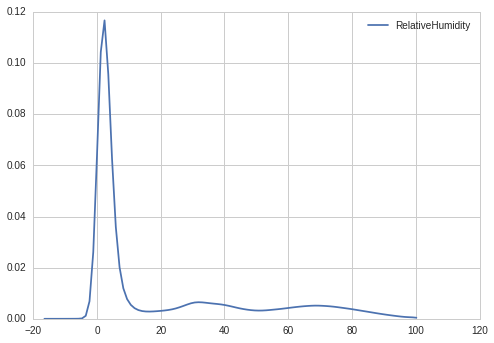

In [79]:
sns.kdeplot(data_model.OutdoorTemperature)

In [45]:
data_model['date'] = data_pol.DateLocal
data_model['weekNo'] = data_model.date.dt.weekofyear
data_model['weekNo']=data_model.weekNo.astype('category')

In [46]:
data_model.dtypes

Carbonmonoxide               float64
DewPoint                     float64
NitrogenDioxide              float64
OutdoorTemperature           float64
Ozone                        float64
PM                           float64
RelativeHumidity             float64
Sulfurdioxide                float64
date                  datetime64[ns]
weekNo                      category
dtype: object

In [47]:
RandomState = 42
train = data_model.sample(frac=0.7,random_state=RandomState)
test = data_model[~(data_model.index.isin(train.index))]

In [ ]:
rf = RandomForestRegressor(oob_score=True,
                           random_state=RandomState,
                           n_estimators=250)


rf.fit(X=train[['Carbonmonoxide',
                'DewPoint',
                'NitrogenDioxide',
                'OutdoorTemperature',
                'Ozone',
                'RelativeHumidity',
                'Sulfurdioxide',
                'weekNo']],
       y=train.PM
)

In [93]:
path_plot+'MICE.png'

'../plots/Matrix_completion_results_MICE.png'

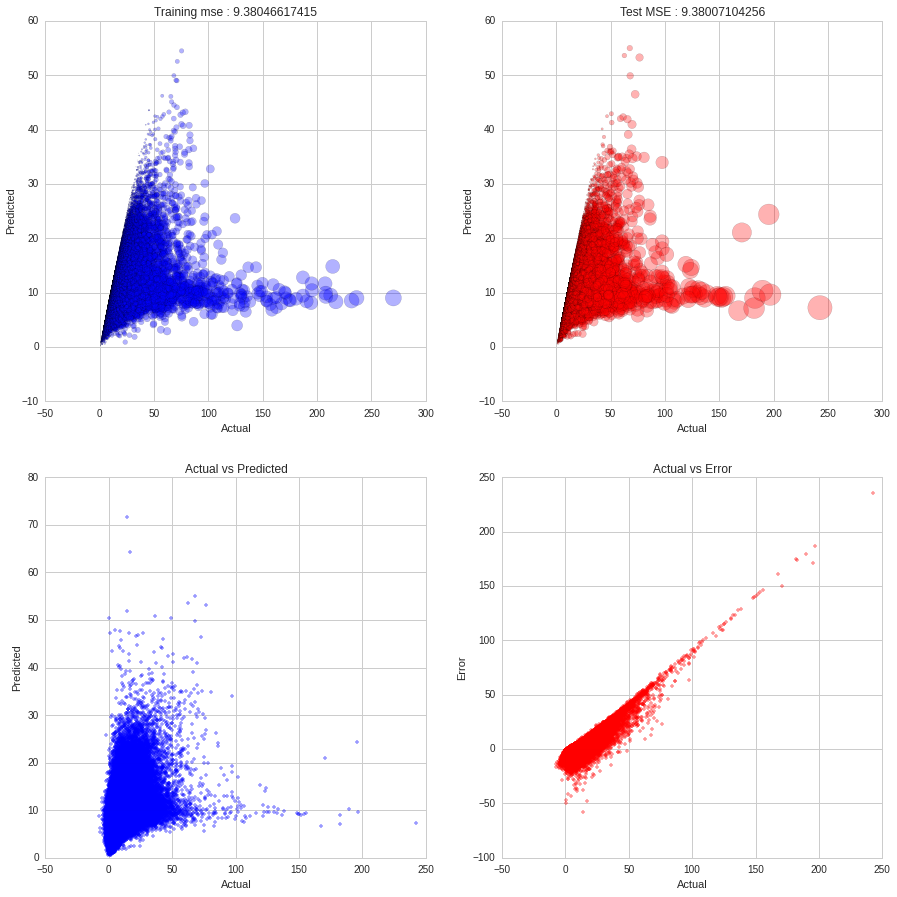

In [97]:
path_plot = '../plots/Matrix_completion_results_'


x_train = train.PM
y_train = rf.oob_prediction_
error_train = x_train-y_train

x_test = test.PM
y_test = rf.predict(test[['Carbonmonoxide',
                            'DewPoint',
                            'NitrogenDioxide',
                            'OutdoorTemperature',
                            'Ozone',
                            'RelativeHumidity',
                            'Sulfurdioxide',
                            'weekNo']])
error_test = x_test-y_test

q = pd.DataFrame({  'x':x_test,
                    'y':y_test,
                    'error_test':error_test
                }).reset_index(drop=True)
q = q.sort(['x'],inplace=False)


mice_plot = sns.plt.figure(figsize=(15,15))
sns.set_style('whitegrid')


mice_plot.add_subplot(221)
sns.plt.scatter(x_train,y_train,
                s = error_train,c='blue',alpha=0.3)
sns.plt.title('Training mse : '+str(np.mean(y_train)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(222)
sns.plt.scatter(x_test,y_test,
                s = error_test,c='red',alpha=0.3)
sns.plt.title('Test MSE : '+str(np.mean(y_test)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(223)
sns.plt.plot(q.x,q.y,
             '.',alpha=0.4,color='b')
sns.plt.title('Actual vs Predicted')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(224)
sns.plt.plot(q.x,q.error_test,'.',alpha=0.4,color='r')
sns.plt.title('Actual vs Error')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Error')




plt.savefig(path_plot+'MICE.PNG',dpi = 750)

In [120]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

X = train[['Carbonmonoxide',
                            'DewPoint',
                            'NitrogenDioxide',
                            'OutdoorTemperature',
                            'Ozone',
                            'RelativeHumidity',
                            'Sulfurdioxide',
                            'weekNo']]
y = train.PM

In [121]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestRegressor(warm_start=True,
                              oob_score=True,
                              max_features="sqrt",
                              random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(warm_start=True,
                              max_features='log2',
                              oob_score=True,
                              random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestRegressor(warm_start=True,
                              max_features=None,
                              oob_score=True,
                              random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [122]:
# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

/software/python/2.7.10/b1/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


KeyboardInterrupt: 

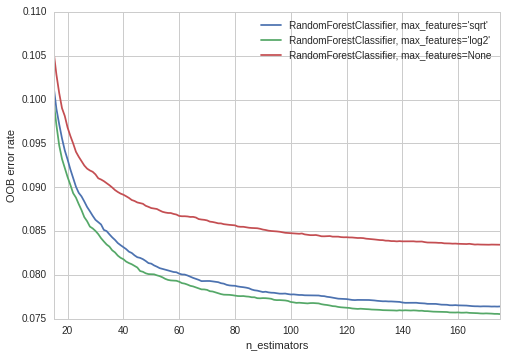

In [34]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
sns.plt.figure(figsize=(15,5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")